In [1]:
import pickle
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import altair as alt
import re
from pprint import pprint
from imblearn.over_sampling import SMOTE,ADASYN
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, ShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
warnings.filterwarnings('ignore')
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,ExtraTreesClassifier,ExtraTreesRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBRegressor,XGBClassifier

from sklearn.ensemble import VotingClassifier,VotingRegressor

from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import StackingClassifier, StackingRegressor
from mlxtend.classifier import StackingClassifier as stc
from mlxtend.regressor import StackingRegressor as strg

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report,mean_squared_error

In [2]:
df = pd.read_csv('deep_learning_df.csv', delimiter = ',')
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,GENE_NAME,AGE,TUMOUR_ORIGIN,TIER,PROTEIN_PRIMARY_STRUCTURE,IS MEALANOMA ?
0,0,48.0,1,1,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDE,0
1,1,0.0,1,1,MAALSGGGGGGAEPGQALFNGDMEPEAGAGAGAAASSAADPAIPEE...,0
2,1,57.0,0,1,MAALSGGGGGGAEPGQALFNGDMEPEAGAGAGAAASSAADPAIPEE...,0
3,2,49.0,0,2,MLKPSGLPGSSSPTRSLMTGSRSTKATPEMDSGLTGATLSPKTSTG...,0
4,2,73.0,0,2,MLKPSGLPGSSSPTRSLMTGSRSTKATPEMDSGLTGATLSPKTSTG...,0


In [3]:
df.shape

(33906, 6)

In [4]:
 # {'A' : 0, 'C' : 1, 'D' : 2, 'E' : 3, 'F' : 4, 'G' : 5, 'H' : 6, 'I' : 7, 'K' : 8, 'L' : 9, 'M' : 10, 'N' : 11, 'P' : 12, 'Q' : 13, 'R' : 14, 'S' : 15, 'T' : 16, 'V' : 17, 'W' : 18, 'Y' : 19}
    
amino_acids = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']    

In [5]:
size = len(amino_acids)
columns = []
for i in range(size):
    for j in range(size):
        columns.append(f"{amino_acids[i]}->{amino_acids[j]}")

In [6]:
len(columns)

400

In [7]:
def amino_acid_dist(seq):
    
    dist = dict()
    for col in columns:
        dist[col] = 0
    
    size = len(seq)
    for i in range(size-1):
        dist[f"{seq[i]}->{seq[i+1]}"] += 1
        
    return dist

In [8]:
import requests
from string import Template

BASE_URL = 'https://cancer.sanger.ac.uk/cosmic/'
SEQUENCE_URL = Template('sequence?ln=$gene&type=$_type')

'''
    @params 
        gene - Gene Type
        _type - Sequnce Type (DNA or Protein)
    
    @returns 
        sequence (String)
'''
def get_sequence(gene='BRAF', _type='cdna'):
    URL = BASE_URL + SEQUENCE_URL.substitute(gene=gene,_type=_type)
    print(f'GET -----> {URL}')
    request = requests.get(url = URL)
    sequence = request.text
    sequence = sequence.split('\n')
    sequence = ''.join(sequence[1:len(sequence)-1])
    if _type.lower() == 'protein':
        sequence = sequence[:len(sequence)-1]
    return sequence

In [9]:
# get genes DNA sequence from COSMIC API
GENE_NAMES = ['BRAF','MUC16','NRAS','LRP1B']
GENES = dict()

for gene in GENE_NAMES:
    GENES[gene] = get_sequence(gene)

GET -----> https://cancer.sanger.ac.uk/cosmic/sequence?ln=BRAF&type=cdna
GET -----> https://cancer.sanger.ac.uk/cosmic/sequence?ln=MUC16&type=cdna
GET -----> https://cancer.sanger.ac.uk/cosmic/sequence?ln=NRAS&type=cdna
GET -----> https://cancer.sanger.ac.uk/cosmic/sequence?ln=LRP1B&type=cdna


In [10]:
# define codon table
protein = {"TTT" : "F", "CTT" : "L", "ATT" : "I", "GTT" : "V",
           "TTC" : "F", "CTC" : "L", "ATC" : "I", "GTC" : "V",
           "TTA" : "L", "CTA" : "L", "ATA" : "I", "GTA" : "V",
           "TTG" : "L", "CTG" : "L", "ATG" : "M", "GTG" : "V",
           "TCT" : "S", "CCT" : "P", "ACT" : "T", "GCT" : "A",
           "TCC" : "S", "CCC" : "P", "ACC" : "T", "GCC" : "A",
           "TCA" : "S", "CCA" : "P", "ACA" : "T", "GCA" : "A",
           "TCG" : "S", "CCG" : "P", "ACG" : "T", "GCG" : "A",
           "TAT" : "Y", "CAT" : "H", "AAT" : "N", "GAT" : "D",
           "TAC" : "Y", "CAC" : "H", "AAC" : "N", "GAC" : "D",
           "TAA" : "STOP", "CAA" : "Q", "AAA" : "K", "GAA" : "E",
           "TAG" : "STOP", "CAG" : "Q", "AAG" : "K", "GAG" : "E",
           "TGT" : "C", "CGT" : "R", "AGT" : "S", "GGT" : "G",
           "TGC" : "C", "CGC" : "R", "AGC" : "S", "GGC" : "G",
           "TGA" : "STOP", "CGA" : "R", "AGA" : "R", "GGA" : "G",
           "TGG" : "W", "CGG" : "R", "AGG" : "R", "GGG" : "G" 
           }

def dna_to_protein(dna):
    '''
        This function takes dna sequence as string 
        and convert into amino acid sequence 
    '''
    
    protein_sequence = ""

    # Generate protein sequence
    for i in range(0, len(dna)-(3+len(dna)%3), 3):
        if protein[dna[i:i+3]] == "STOP" :
            break
        protein_sequence += protein[dna[i:i+3]]
        
    return protein_sequence

In [11]:
BRAF_dist = amino_acid_dist(dna_to_protein(GENES['BRAF']))
assert len(BRAF_dist) == 400

In [12]:
MUC16_dist = amino_acid_dist(dna_to_protein(GENES['MUC16']))
assert len(MUC16_dist) == 400

In [13]:
LRP1B_dist = amino_acid_dist(dna_to_protein(GENES['LRP1B']))
assert len(LRP1B_dist) == 400

In [14]:
NRAS_dist = amino_acid_dist(dna_to_protein(GENES['NRAS']))
assert len(NRAS_dist) == 400

In [15]:
df.head()

,GENE_NAME,AGE,TUMOUR_ORIGIN,TIER,PROTEIN_PRIMARY_STRUCTURE,IS MEALANOMA ?
0,0,48.0,1,1,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDE,0
1,1,0.0,1,1,MAALSGGGGGGAEPGQALFNGDMEPEAGAGAGAAASSAADPAIPEE...,0
2,1,57.0,0,1,MAALSGGGGGGAEPGQALFNGDMEPEAGAGAGAAASSAADPAIPEE...,0
3,2,49.0,0,2,MLKPSGLPGSSSPTRSLMTGSRSTKATPEMDSGLTGATLSPKTSTG...,0
4,2,73.0,0,2,MLKPSGLPGSSSPTRSLMTGSRSTKATPEMDSGLTGATLSPKTSTG...,0


In [16]:
df.columns

Index(['GENE_NAME', 'AGE', 'TUMOUR_ORIGIN', 'TIER',
       'PROTEIN_PRIMARY_STRUCTURE', 'IS MEALANOMA ?'],
      dtype='object')

In [17]:
GENE_NAME_CODES = {'NRAS': 0, 'BRAF': 1, 'MUC16': 2, 'LRP1B': 3}

In [18]:
array = list()

for index, row in df.iterrows():

    if row['GENE_NAME'] == GENE_NAME_CODES['BRAF']:
        dist = BRAF_dist.copy()
    elif row['GENE_NAME'] == GENE_NAME_CODES['MUC16']:
        dist = MUC16_dist.copy()
    elif row['GENE_NAME'] == GENE_NAME_CODES['LRP1B']:
        dist = LRP1B_dist.copy()
    elif row['GENE_NAME'] == GENE_NAME_CODES['NRAS']:
        dist = NRAS_dist.copy()
    else:
        raise Exception(f'Unknown gene name : %s',row['GENE_NAME'])
        
    data_point = {'GENE_NAME' : row['GENE_NAME'] ,  'AGE' : row[ 'AGE'] , 'TUMOUR_ORIGIN' : row['TUMOUR_ORIGIN'] , 'TIER' : row['TIER']}
                
    actual = amino_acid_dist(row['PROTEIN_PRIMARY_STRUCTURE'])
    
    actual = {key: actual[key] - dist.get(key, 0) for key in dist.keys()}
    
    data_point = {**data_point, **actual}
    
    data_point['IS MELANOMA ?'] = row['IS MEALANOMA ?']
    
    array.append(data_point)
    
    
df2 = pd.DataFrame(array)
df2.head()

,GENE_NAME,AGE,TUMOUR_ORIGIN,TIER,A->A,A->C,A->D,A->E,A->F,A->G,...,Y->N,Y->P,Y->Q,Y->R,Y->S,Y->T,Y->V,Y->W,Y->Y,IS MELANOMA ?
0,0,48.0,1,1,0,0,-1,0,-1,-1,...,0,0,0,-3,-1,-1,0,0,0,0
1,1,0.0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,57.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,49.0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,73.0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
df2.isnull().any()

GENE_NAME        False
AGE              False
TUMOUR_ORIGIN    False
TIER             False
A->A             False
                 ...  
Y->T             False
Y->V             False
Y->W             False
Y->Y             False
IS MELANOMA ?    False
Length: 405, dtype: bool

[0.03204311 0.3633189  0.58012559 0.0245124 ]


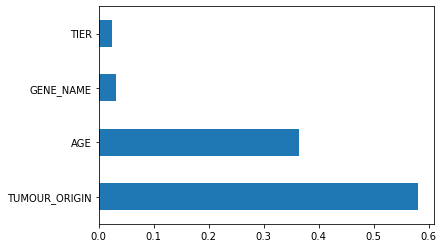

In [20]:
X = df2[['GENE_NAME', 'AGE','TUMOUR_ORIGIN','TIER']]
y = df2['IS MELANOMA ?']

model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) # use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

<AxesSubplot:title={'center':'Melanoma Yes/No'}>

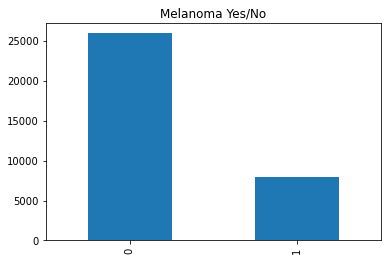

In [21]:
# check for class imbalance
df2['IS MELANOMA ?'].value_counts().plot(kind='bar', title='Melanoma Yes/No')

In [22]:
# define features as X and target as y
X = df2.drop('IS MELANOMA ?',axis=1)
y = df2['IS MELANOMA ?']

In [23]:
# apply ADASYN (Adaptive Synthetic)
ada = ADASYN()
X_ada ,y_ada = ada.fit_resample(X,y)

<AxesSubplot:title={'center':'Melanoma Yes/No'}>

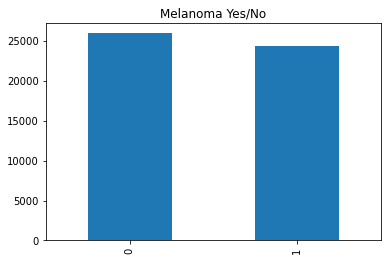

In [24]:
# check for class imbalance
y_ada.value_counts().plot(kind='bar', title='Melanoma Yes/No')

In [25]:
# spliting dataset
X_train,X_test,y_train,y_test = train_test_split(X_ada,y_ada,test_size=0.2,random_state = 101)

# reset indexes
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X_train.head(5)

,GENE_NAME,AGE,TUMOUR_ORIGIN,TIER,A->A,A->C,A->D,A->E,A->F,A->G,...,Y->M,Y->N,Y->P,Y->Q,Y->R,Y->S,Y->T,Y->V,Y->W,Y->Y
0,1,0.0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,52.0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,35.0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,25.0,2,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40292, 404), (10073, 404), (40292,), (10073,))

In [27]:
mod = PCA(n_components = 3)
mod.fit(X_train, y_train)

PCA(n_components=3)

In [28]:
sum(mod.explained_variance_ratio_)

0.992494226909212

In [29]:
X_pca = mod.transform(X_train)

X_pca_test = mod.transform(X_test)

In [27]:
# import required libraries
import pickle
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import altair as alt
import re
from pprint import pprint
from imblearn.over_sampling import SMOTE,ADASYN
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, ShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
warnings.filterwarnings('ignore')
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,ExtraTreesClassifier,ExtraTreesRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBRegressor,XGBClassifier

from sklearn.ensemble import VotingClassifier,VotingRegressor

from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import StackingClassifier, StackingRegressor
from mlxtend.classifier import StackingClassifier as stc
from mlxtend.regressor import StackingRegressor as strg

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report,mean_squared_error

### 1. Logistic Regression

#### Cross-Validation for Hyperparameter tuning

In [31]:
lr_0 = LogisticRegression(random_state = 8)

print('Parameters currently in use:\n')
pprint(lr_0.get_params())

Parameters currently in use:

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 8,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


* `C` = Inverse of regularization strength. Smaller values specify stronger regularization.
* `multi_class` = We'll choose `multinomial` because this is a multi-class problem.
* `solver` = Algorithm to use in the optimization problem. For multiclass problems, only `newton-cg`, `sag`, `saga` and `lbfgs` handle multinomial loss.
* `class_weight`: Weights associated with classes. 
* `penalty`: Used to specify the norm used in the penalization. The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties.

#### Randomized Search Cross Validation

In [32]:
# C
C = [float(x) for x in np.linspace(start = 0.1, stop = 1, num = 10)]

# multi_class
multi_class = ['auto']

# solver
solver = ['newton-cg', 'sag', 'saga', 'lbfgs']
 
# class_weight
class_weight = [None]

# penalty
penalty = ['l2']

# Create the random grid
random_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

pprint(random_grid)

{'C': [0.1,
       0.2,
       0.30000000000000004,
       0.4,
       0.5,
       0.6,
       0.7000000000000001,
       0.8,
       0.9,
       1.0],
 'class_weight': [None],
 'multi_class': ['auto'],
 'penalty': ['l2'],
 'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']}


In [33]:
# First create the base model to tune
lrc = LogisticRegression(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=lrc,
                                   param_distributions=random_grid,
                                   n_iter=10,
                                   scoring='f1_macro',
                                   cv=5, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(random_state=8),
                   param_distributions={'C': [0.1, 0.2, 0.30000000000000004,
                                              0.4, 0.5, 0.6, 0.7000000000000001,
                                              0.8, 0.9, 1.0],
                                        'class_weight': [None],
                                        'multi_class': ['auto'],
                                        'penalty': ['l2'],
                                        'solver': ['newton-cg', 'sag', 'saga',
                                                   'lbfgs']},
                   random_state=8, scoring='f1_macro', verbose=1)

In [34]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'solver': 'newton-cg', 'penalty': 'l2', 'multi_class': 'auto', 'class_weight': None, 'C': 0.5}

The mean accuracy of a model with these hyperparameters is:
0.5827302812630755


#### Grid Search Cross Validation

In [35]:
# Create the parameter grid based on the results of random search 
C = [float(x) for x in np.linspace(start = 0.01, stop = 1.0, num = 10)]
multi_class = ['auto']
solver = ['lbfgs']
class_weight = [None]
penalty = ['l2']

param_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

# Create a base model
lrc = LogisticRegression(random_state=8)
cv_sets = ShuffleSplit(n_splits = 5, test_size = .2, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=lrc, 
                           param_grid=param_grid,
                           scoring='f1_macro',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=8, test_size=0.2, train_size=None),
             estimator=LogisticRegression(random_state=8),
             param_grid={'C': [0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78,
                               0.89, 1.0],
                         'class_weight': [None], 'multi_class': ['auto'],
                         'penalty': ['l2'], 'solver': ['lbfgs']},
             scoring='f1_macro', verbose=1)

In [36]:
# select best estimator
best_lrc = grid_search.best_estimator_

In [37]:
best_lrc.fit(X_train, y_train)

LogisticRegression(C=0.56, random_state=8)

In [38]:
print("The training accuracy is: ")
print(accuracy_score(y_train, best_lrc.predict(X_train)))

The training accuracy is: 
0.5694545114452056


In [39]:
print("The test accuracy is: ")
print(accuracy_score(y_test, best_lrc.predict(X_test)))

The test accuracy is: 
0.5588702889740952


In [40]:
print("Classification report for training")
print(classification_report(y_train,best_lrc.predict(X_train)))

Classification report for training
              precision    recall  f1-score   support

           0       0.55      0.60      0.58     20715
           1       0.59      0.54      0.56     22054

    accuracy                           0.57     42769
   macro avg       0.57      0.57      0.57     42769
weighted avg       0.57      0.57      0.57     42769



In [41]:
print("Classification report for testing")
print(classification_report(y_test,best_lrc.predict(X_test)))

Classification report for testing
              precision    recall  f1-score   support

           0       0.55      0.59      0.57      5230
           1       0.57      0.53      0.55      5463

    accuracy                           0.56     10693
   macro avg       0.56      0.56      0.56     10693
weighted avg       0.56      0.56      0.56     10693



Confusion Matrix for Training


<Figure size 720x720 with 0 Axes>

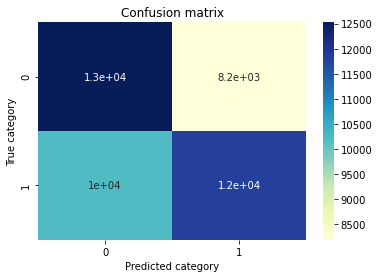

In [42]:
print('Confusion Matrix for Training')
cnf_matrix = confusion_matrix(y_train, best_lrc.predict(X_train))
plt.figure(figsize = (10,10))
fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, annot=True,cmap="YlGnBu")
plt.title('Confusion matrix')
plt.ylabel('True category')
plt.xlabel('Predicted category')
plt.show()   

Confusion Matrix for Testing


<Figure size 720x720 with 0 Axes>

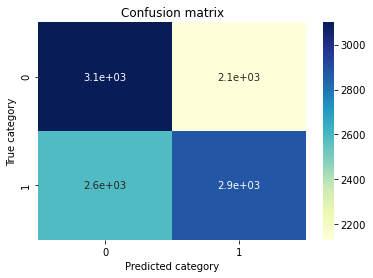

In [43]:
print('Confusion Matrix for Testing')
cnf_matrix = confusion_matrix(y_test, best_lrc.predict(X_test))
plt.figure(figsize = (10,10))
fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, annot=True,cmap="YlGnBu")
plt.title('Confusion matrix')
plt.ylabel('True category')
plt.xlabel('Predicted category')
plt.savefig('figures/logistic_regression.jpg')
plt.show()   

### 2. Random Forest

In [28]:
rf_0 = RandomForestClassifier(random_state = 8)

print('Parameters currently in use:\n')
pprint(rf_0.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 8,
 'verbose': 0,
 'warm_start': False}


We'll tune the following ones:

* `n_estimators` = number of trees in the forest.
* `max_features` = max number of features considered for splitting a node
* `max_depth` = max number of levels in each decision tree
* `min_samples_split` = min number of data points placed in a node before the node is split
* `min_samples_leaf` = min number of data points allowed in a leaf node
* `bootstrap` = method for sampling data points (with or without replacement)

#### Randomized Search Cross Validation

In [29]:
# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

# min_samples_split
min_samples_split = [5, 10, 15]

# min_samples_leaf
min_samples_leaf = [4, 5, 6]

# bootstrap
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [20, 40, 60, 80, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [4, 5, 6],
 'min_samples_split': [5, 10, 15],
 'n_estimators': [200, 400, 600, 800, 1000]}


In [30]:
# First create the base model to tune
rfc = RandomForestClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=10,
                                   scoring='f1_macro',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=8),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [20, 40, 60, 80, 100,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [4, 5, 6],
                                        'min_samples_split': [5, 10, 15],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   random_state=8, scoring='f1_macro', verbose=1)

In [31]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': False}

The mean accuracy of a model with these hyperparameters is:
0.6293783043327681


#### Grid Search Cross Validation

In [32]:
# Create the parameter grid based on the results of random search 
bootstrap = [False]
max_depth = [80]
max_features = ['auto']
min_samples_leaf = [5, 6, 7]
min_samples_split = [5, 6, 7]
n_estimators = [800]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

# Create a base model
rfc = RandomForestClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 5, test_size = .2, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid,
                           scoring='f1_macro',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=8, test_size=0.2, train_size=None),
             estimator=RandomForestClassifier(random_state=8),
             param_grid={'bootstrap': [False], 'max_depth': [80],
                         'max_features': ['auto'],
                         'min_samples_leaf': [5, 6, 7],
                         'min_samples_split': [5, 6, 7],
                         'n_estimators': [800]},
             scoring='f1_macro', verbose=1)

In [33]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'bootstrap': False, 'max_depth': 80, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 800}

The mean accuracy of a model with these hyperparameters is:
0.6371542763429515


In [34]:
best_rfc = grid_search.best_estimator_

In [35]:
best_rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=80, min_samples_leaf=5,
                       min_samples_split=5, n_estimators=800, random_state=8)

In [36]:
print("The training accuracy is: ")
print(accuracy_score(y_train, best_rfc.predict(X_train)))

The training accuracy is: 
0.6759406333763526


In [37]:
print("The test accuracy is: ")
print(accuracy_score(y_test, best_rfc.predict(X_test)))

The test accuracy is: 
0.6564082199940435


In [38]:
print("Classification report for training")
print(classification_report(y_train,best_rfc.predict(X_train)))

Classification report for training
              precision    recall  f1-score   support

           0       0.63      0.88      0.74     20751
           1       0.78      0.46      0.58     19541

    accuracy                           0.68     40292
   macro avg       0.71      0.67      0.66     40292
weighted avg       0.71      0.68      0.66     40292



In [39]:
print("Classification report for testing")
print(classification_report(y_test,best_rfc.predict(X_test)))

Classification report for testing
              precision    recall  f1-score   support

           0       0.62      0.86      0.72      5194
           1       0.74      0.44      0.56      4879

    accuracy                           0.66     10073
   macro avg       0.68      0.65      0.64     10073
weighted avg       0.68      0.66      0.64     10073



Confusion Matrix for Training


<Figure size 720x720 with 0 Axes>

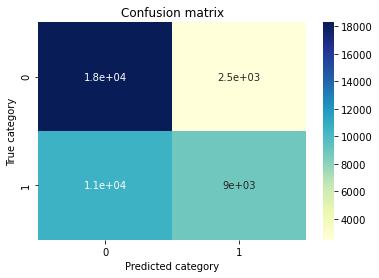

In [40]:
print('Confusion Matrix for Training')
cnf_matrix = confusion_matrix(y_train, best_rfc.predict(X_train))
plt.figure(figsize = (10,10))
fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, annot=True,cmap="YlGnBu")
plt.title('Confusion matrix')
plt.ylabel('True category')
plt.xlabel('Predicted category')
plt.show()   

Confusion Matrix for Testing


<Figure size 720x720 with 0 Axes>

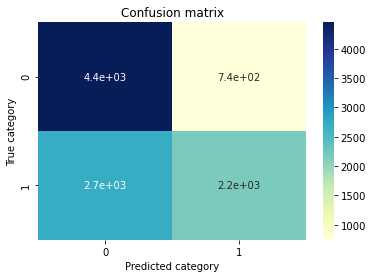

In [41]:
print('Confusion Matrix for Testing')
cnf_matrix = confusion_matrix(y_test, best_rfc.predict(X_test))
plt.figure(figsize = (10,10))
fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, annot=True,cmap="YlGnBu")
plt.title('Confusion matrix')
plt.ylabel('True category')
plt.xlabel('Predicted category')
plt.savefig('figures/random forest.jpg')
plt.show()   

### 4. KNN

In [45]:
knnc_0 = KNeighborsClassifier()

print('Parameters currently in use:\n')
pprint(knnc_0.get_params())

Parameters currently in use:

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}


In [73]:
# Create the parameter grid 
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 500, num = 20)]

param_grid = {'n_neighbors': n_neighbors}

# Create a base model
knnc = KNeighborsClassifier()

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .20, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=knnc, 
                           param_grid=param_grid,
                           scoring='f1_macro',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.2, train_size=None),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 27, 53, 79, 106, 132, 158, 184, 211,
                                         237, 263, 289, 316, 342, 368, 394, 421,
                                         447, 473, 500]},
             scoring='f1_macro', verbose=1)

In [74]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'n_neighbors': 1}

The mean accuracy of a model with these hyperparameters is:
0.574003234192437


In [75]:
n_neighbors = [1, 27, 53, 79, 106, 132, 158, 184, 211,
                                         237, 263, 289, 316, 342, 368, 394, 421,
                                         447, 473, 500]
param_grid = {'n_neighbors': n_neighbors}

knnc = KNeighborsClassifier()
cv_sets = ShuffleSplit(n_splits = 5, test_size = .2, random_state = 8)

grid_search = GridSearchCV(estimator=knnc, 
                           param_grid=param_grid,
                           scoring='f1_macro',
                           cv=cv_sets,
                           verbose=1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=8, test_size=0.2, train_size=None),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 27, 53, 79, 106, 132, 158, 184, 211,
                                         237, 263, 289, 316, 342, 368, 394, 421,
                                         447, 473, 500]},
             scoring='f1_macro', verbose=1)

In [76]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'n_neighbors': 1}

The mean accuracy of a model with these hyperparameters is:
0.5745183411560719


In [77]:
best_knnc = grid_search.best_estimator_

In [78]:
best_knnc.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [79]:
print("The training accuracy is: ")
print(accuracy_score(y_train, best_knnc.predict(X_train)))

The training accuracy is: 
0.7105380065000351


In [80]:
print("The test accuracy is: ")
print(accuracy_score(y_test, best_knnc.predict(X_test)))

The test accuracy is: 
0.5823435892640045


In [81]:
print("Classification report for training")
print(classification_report(y_train,best_knnc.predict(X_train)))

Classification report for training
              precision    recall  f1-score   support

           0       0.77      0.57      0.66     20715
           1       0.68      0.84      0.75     22054

    accuracy                           0.71     42769
   macro avg       0.72      0.71      0.70     42769
weighted avg       0.72      0.71      0.70     42769



In [82]:
print("Classification report for testing")
print(classification_report(y_test,best_knnc.predict(X_test)))

Classification report for testing
              precision    recall  f1-score   support

           0       0.65      0.32      0.43      5230
           1       0.56      0.83      0.67      5463

    accuracy                           0.58     10693
   macro avg       0.60      0.58      0.55     10693
weighted avg       0.60      0.58      0.55     10693



Confusion Matrix for Training


<Figure size 720x720 with 0 Axes>

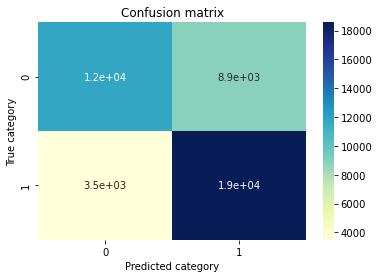

In [83]:
print('Confusion Matrix for Training')
cnf_matrix = confusion_matrix(y_train, best_knnc.predict(X_train))
plt.figure(figsize = (10,10))
fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, annot=True,cmap="YlGnBu")
plt.title('Confusion matrix')
plt.ylabel('True category')
plt.xlabel('Predicted category')
plt.show()   

Confusion Matrix for Testing


<Figure size 720x720 with 0 Axes>

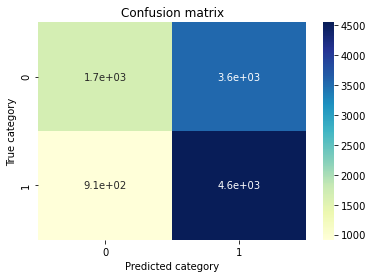

In [84]:
print('Confusion Matrix for Testing')
cnf_matrix = confusion_matrix(y_test, best_knnc.predict(X_test))
plt.figure(figsize = (10,10))
fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, annot=True,cmap="YlGnBu")
plt.title('Confusion matrix')
plt.ylabel('True category')
plt.xlabel('Predicted category')
plt.savefig('figures/knn.jpg')
plt.show()   

### 5. Gradient Boosting Machine

In [59]:
gb_0 = GradientBoostingClassifier(random_state = 8)

print('Parameters currently in use:\n')
pprint(gb_0.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 8,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


We'll tune the following ones:

Tree-related hyperparameters:
* `n_estimators` = number of trees in the forest.
* `max_features` = max number of features considered for splitting a node
* `max_depth` = max number of levels in each decision tree
* `min_samples_split` = min number of data points placed in a node before the node is split
* `min_samples_leaf` = min number of data points allowed in a leaf node

Boosting-related hyperparameters:
* `learning_rate`= learning rate shrinks the contribution of each tree by learning_rate.
* `subsample`= the fraction of samples to be used for fitting the individual base learners.

In [60]:
# n_estimators
n_estimators = [200, 800]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [10, 40]
max_depth.append(None)

# min_samples_split
min_samples_split = [10, 30, 50]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# learning rate
learning_rate = [.1, .5]

# subsample
subsample = [.5, 1.]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': learning_rate,
               'subsample': subsample}

pprint(random_grid)

{'learning_rate': [0.1, 0.5],
 'max_depth': [10, 40, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [10, 30, 50],
 'n_estimators': [200, 800],
 'subsample': [0.5, 1.0]}


In [61]:
# First create the base model to tune
gbc = GradientBoostingClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=gbc,
                                   param_distributions=random_grid,
                                   n_iter=10,
                                   scoring='f1_macro',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(X_train.values, y_train.values)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=8),
                   param_distributions={'learning_rate': [0.1, 0.5],
                                        'max_depth': [10, 40, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [10, 30, 50],
                                        'n_estimators': [200, 800],
                                        'subsample': [0.5, 1.0]},
                   random_state=8, scoring='f1_macro', verbose=1)

In [62]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'subsample': 0.5, 'n_estimators': 800, 'min_samples_split': 30, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'learning_rate': 0.1}

The mean accuracy of a model with these hyperparameters is:
0.6779408016602998


In [63]:
# Create the parameter grid based on the results of random search 
max_depth = [8, 10]
max_features = ['sqrt']
min_samples_leaf = [4,6] 
min_samples_split = [30, 50]
n_estimators = [800]
learning_rate = [.1]
subsample = [0.5]

param_grid = {
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'subsample': subsample

}

# Create a base model
gbc = GradientBoostingClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .2, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=gbc, 
                           param_grid=param_grid,
                           scoring='f1_macro',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train.values, y_train.values)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.2, train_size=None),
             estimator=GradientBoostingClassifier(random_state=8),
             param_grid={'learning_rate': [0.1], 'max_depth': [8, 10],
                         'max_features': ['sqrt'], 'min_samples_leaf': [4, 6],
                         'min_samples_split': [30, 50], 'n_estimators': [800],
                         'subsample': [0.5]},
             scoring='f1_macro', verbose=1)

In [64]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'learning_rate': 0.1, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 30, 'n_estimators': 800, 'subsample': 0.5}

The mean accuracy of a model with these hyperparameters is:
0.682064867771761


In [65]:
best_gbc = grid_search.best_estimator_

In [66]:
best_gbc.fit(X_train.values, y_train.values)

GradientBoostingClassifier(max_depth=10, max_features='sqrt',
                           min_samples_leaf=4, min_samples_split=30,
                           n_estimators=800, random_state=8, subsample=0.5)

In [67]:
print("The training accuracy is: ")
print(accuracy_score(y_train, best_gbc.predict(X_train)))

The training accuracy is: 
0.7076620917019336


In [68]:
print("The test accuracy is: ")
print(accuracy_score(y_test, best_gbc.predict(X_test)))

The test accuracy is: 
0.6897035443748246


In [69]:
print("Classification report for training")
print(classification_report(y_train,best_gbc.predict(X_train)))

Classification report for training
              precision    recall  f1-score   support

           0       0.64      0.89      0.75     20715
           1       0.84      0.53      0.65     22054

    accuracy                           0.71     42769
   macro avg       0.74      0.71      0.70     42769
weighted avg       0.74      0.71      0.70     42769



In [70]:
print("Classification report for testing")
print(classification_report(y_test,best_gbc.predict(X_test)))

Classification report for testing
              precision    recall  f1-score   support

           0       0.63      0.87      0.73      5230
           1       0.81      0.52      0.63      5463

    accuracy                           0.69     10693
   macro avg       0.72      0.69      0.68     10693
weighted avg       0.72      0.69      0.68     10693



Confusion Matrix for Training


<Figure size 720x720 with 0 Axes>

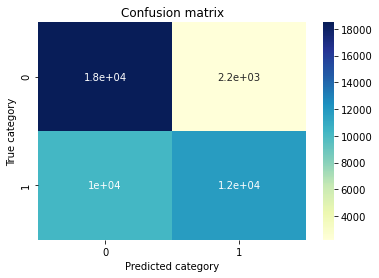

In [71]:
print('Confusion Matrix for Training')
cnf_matrix = confusion_matrix(y_train, best_gbc.predict(X_train))
plt.figure(figsize = (10,10))
fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, annot=True,cmap="YlGnBu")
plt.title('Confusion matrix')
plt.ylabel('True category')
plt.xlabel('Predicted category')
plt.show()   

Confusion Matrix for Testing


<Figure size 720x720 with 0 Axes>

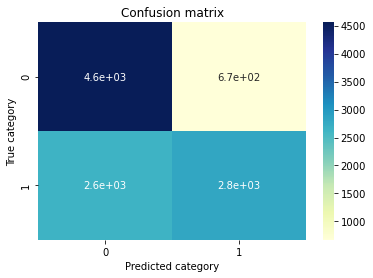

In [72]:
print('Confusion Matrix for Testing')
cnf_matrix = confusion_matrix(y_test, best_gbc.predict(X_test))
plt.figure(figsize = (10,10))
fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, annot=True,cmap="YlGnBu")
plt.title('Confusion matrix')
plt.ylabel('True category')
plt.xlabel('Predicted category')
plt.savefig('figures/gb.jpg')
plt.show()   